In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, HuberRegressor, TheilSenRegressor, RANSACRegressor
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import (
    PolynomialFeatures,
    MinMaxScaler,
    StandardScaler,
    RobustScaler,
    PowerTransformer,
    QuantileTransformer,
    OneHotEncoder,
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import scipy.stats as st
from sklearn.preprocessing import label_binarize
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from sklearn.feature_selection import mutual_info_regression
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
df = pd.read_csv('train .csv')

# Очистка данных

In [3]:
df["TotalSpent"] = df["TotalSpent"].apply(lambda x: "0" if x == " " else x)
df = df.astype({"TotalSpent": "float64"})

In [4]:
print(len(df))
df = df.drop_duplicates()
print(len(df))

5282
5268


In [5]:
df["HasMovieSubscription"] = df["HasMovieSubscription"].apply(lambda x: "No" if x == "No internet service" else x)
df["HasMultiplePhoneNumbers"] = df["HasMultiplePhoneNumbers"].apply(lambda x: "No" if x == "No phone service" else x)
df["HasOnlineSecurityService"] = df["HasOnlineSecurityService"].apply(lambda x: "No" if x == "No internet service" else x)
df["HasOnlineBackup"] = df["HasOnlineBackup"].apply(lambda x: "No" if x == "No internet service" else x)
df["HasDeviceProtection"] = df["HasDeviceProtection"].apply(lambda x: "No" if x == "No internet service" else x)
df["HasTechSupportAccess"] = df["HasTechSupportAccess"].apply(lambda x: "No" if x == "No internet service" else x)
df["HasOnlineTV"] = df["HasOnlineTV"].apply(lambda x: "No" if x == "No internet service" else x)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5268 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5268 non-null   int64  
 1   MonthlySpending           5268 non-null   float64
 2   TotalSpent                5268 non-null   float64
 3   Sex                       5268 non-null   object 
 4   IsSeniorCitizen           5268 non-null   int64  
 5   HasPartner                5268 non-null   object 
 6   HasChild                  5268 non-null   object 
 7   HasPhoneService           5268 non-null   object 
 8   HasMultiplePhoneNumbers   5268 non-null   object 
 9   HasInternetService        5268 non-null   object 
 10  HasOnlineSecurityService  5268 non-null   object 
 11  HasOnlineBackup           5268 non-null   object 
 12  HasDeviceProtection       5268 non-null   object 
 13  HasTechSupportAccess      5268 non-null   object 
 14  HasOnlineTV  

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ClientPeriod,5268.0,32.480448,24.529439,0.00,9.0000,29.00,55.0000,72.00
MonthlySpending,5268.0,64.977563,30.176025,18.25,35.5375,70.45,90.0500,118.75
TotalSpent,5268.0,2293.445549,2269.111393,0.00,401.9250,1411.50,3808.6375,8684.80
IsSeniorCitizen,5268.0,0.159643,0.366310,0.00,0.0000,0.00,0.0000,1.00
Churn,5268.0,0.260820,0.439124,0.00,0.0000,0.00,1.0000,1.00


In [8]:
translations = {}

def eda_visualize(column, xlim=None):
    xlabel = translations.get(column.name, column.name)
    fig, axes = plt.subplots(1, 2, figsize=(16,6))
    sns.histplot(column, ax=axes[0], bins=25, kde=False)
    axes[0].set(title='Гистограмма', xlabel=xlabel, ylabel='Наблюдений, шт.', xlim=xlim)
    sns.violinplot(column, ax=axes[1], orient='h')
    axes[1].set(title='Плотность и размах', xlabel=xlabel, xlim=xlim)

In [9]:
def churn_by_category(category):
    df.groupby(['Churn', category]).size().unstack(fill_value=0).plot(kind='bar', stacked=True);

# Первичный анализ данных

## Категориальные

In [10]:
df["Churn"].value_counts(normalize=True)

Churn
0    0.73918
1    0.26082
Name: proportion, dtype: float64

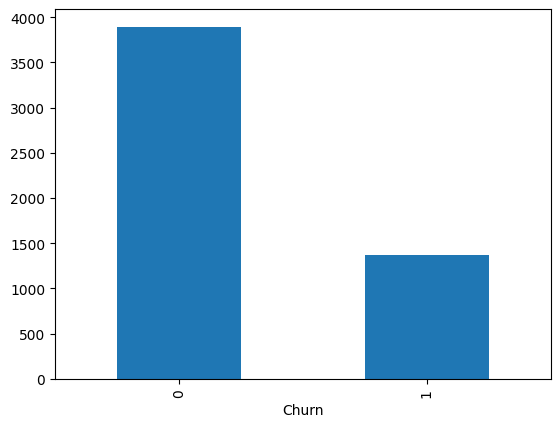

In [11]:
df["Churn"].value_counts().plot(kind="bar");

In [12]:
categorical_cols = [
    'HasPartner',
    'Sex',
    'IsSeniorCitizen',
    'HasPhoneService',
    'HasMovieSubscription',
    'HasChild',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod',
]

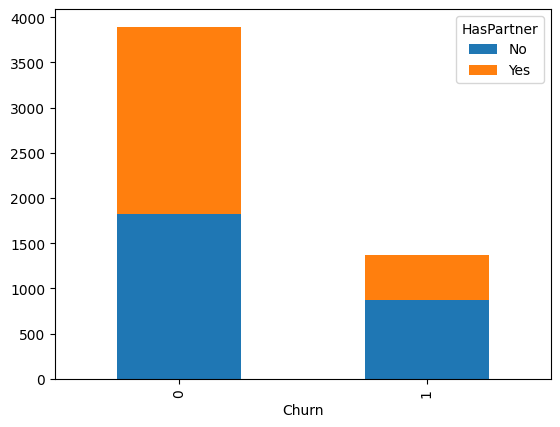

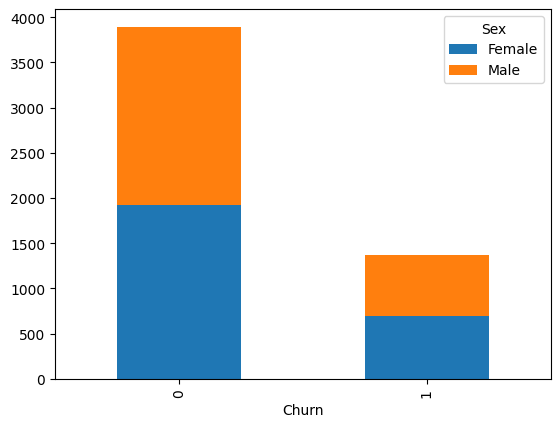

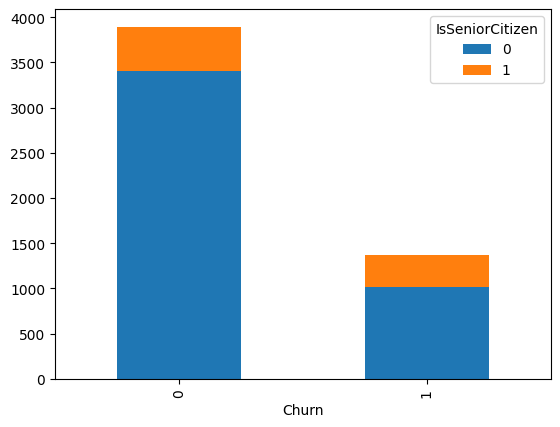

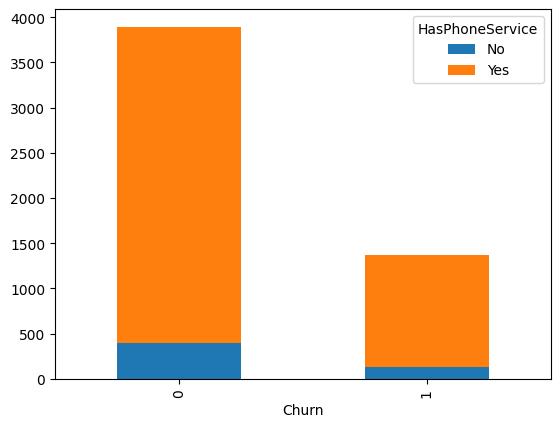

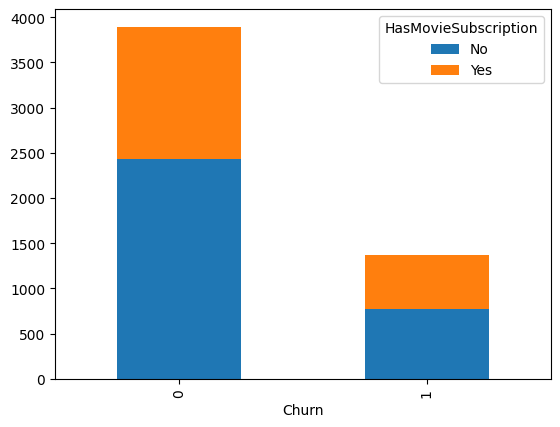

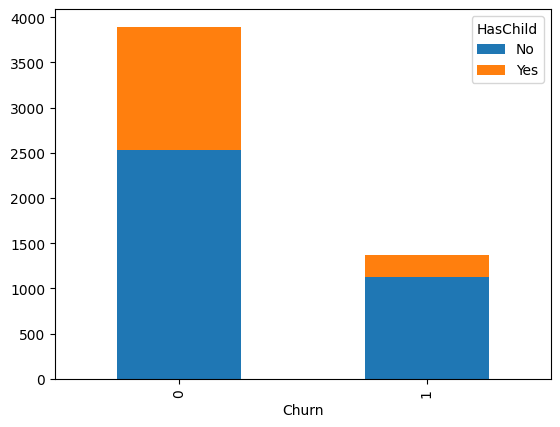

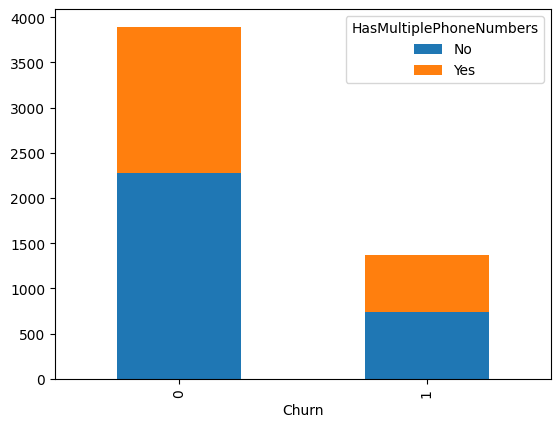

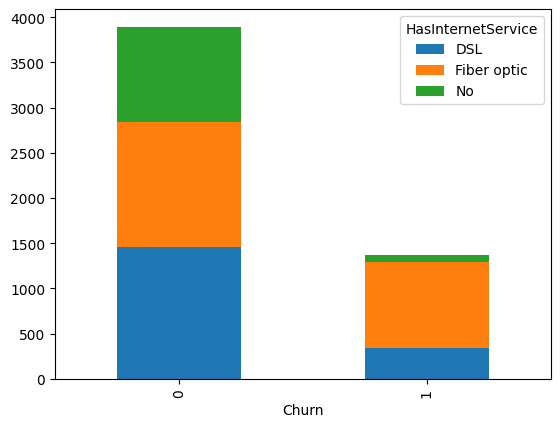

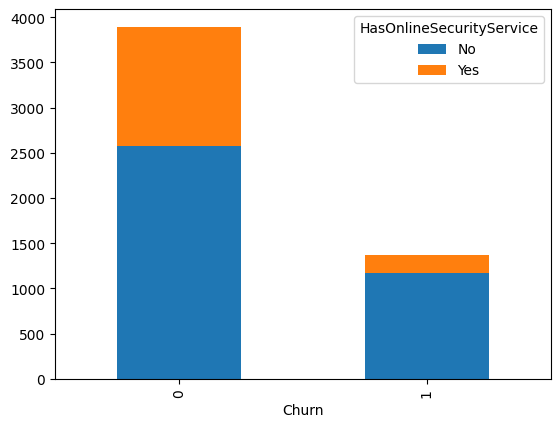

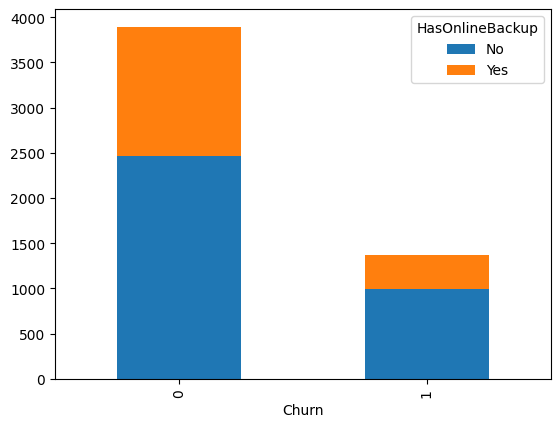

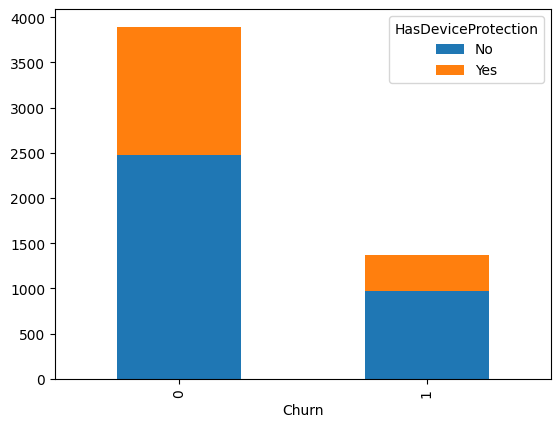

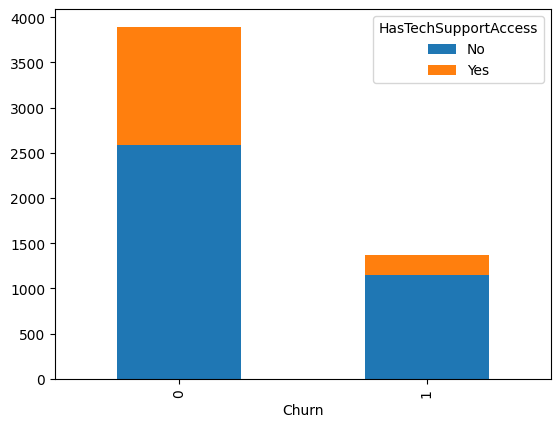

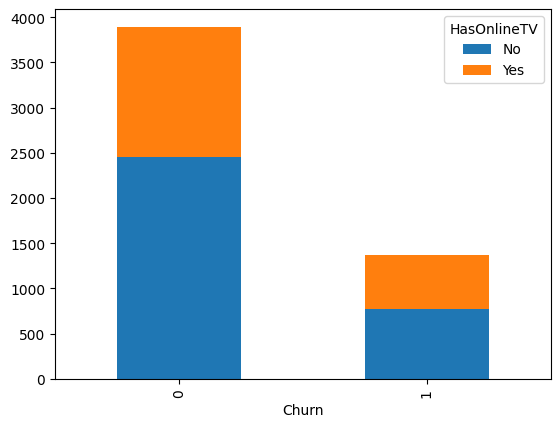

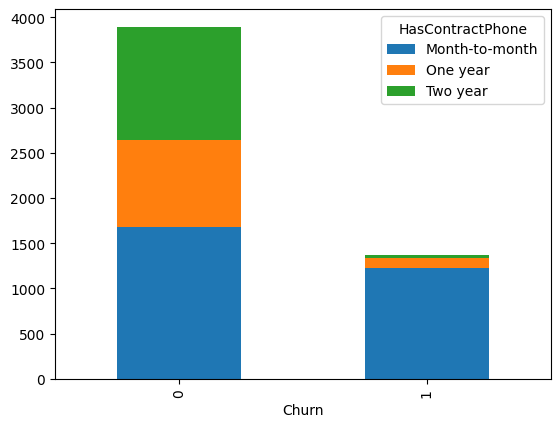

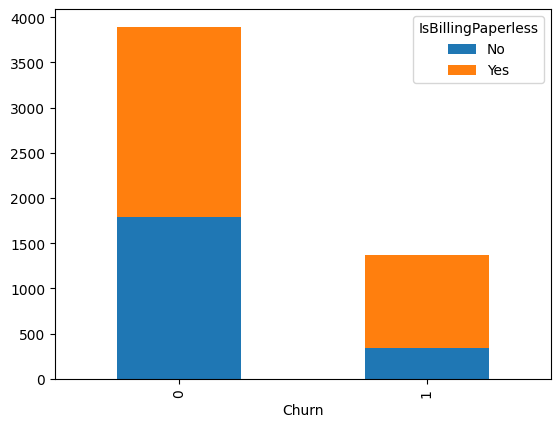

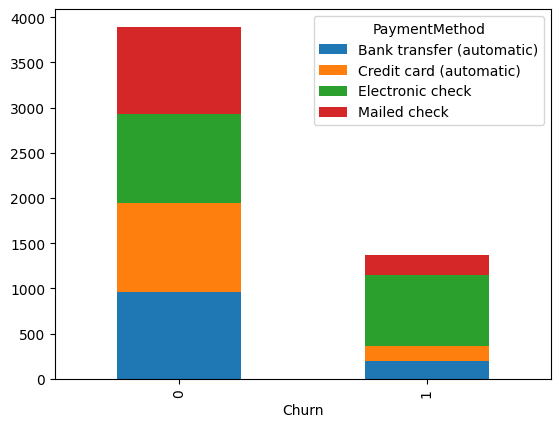

In [13]:
for col in categorical_cols:
    churn_by_category(col)

## Числовые

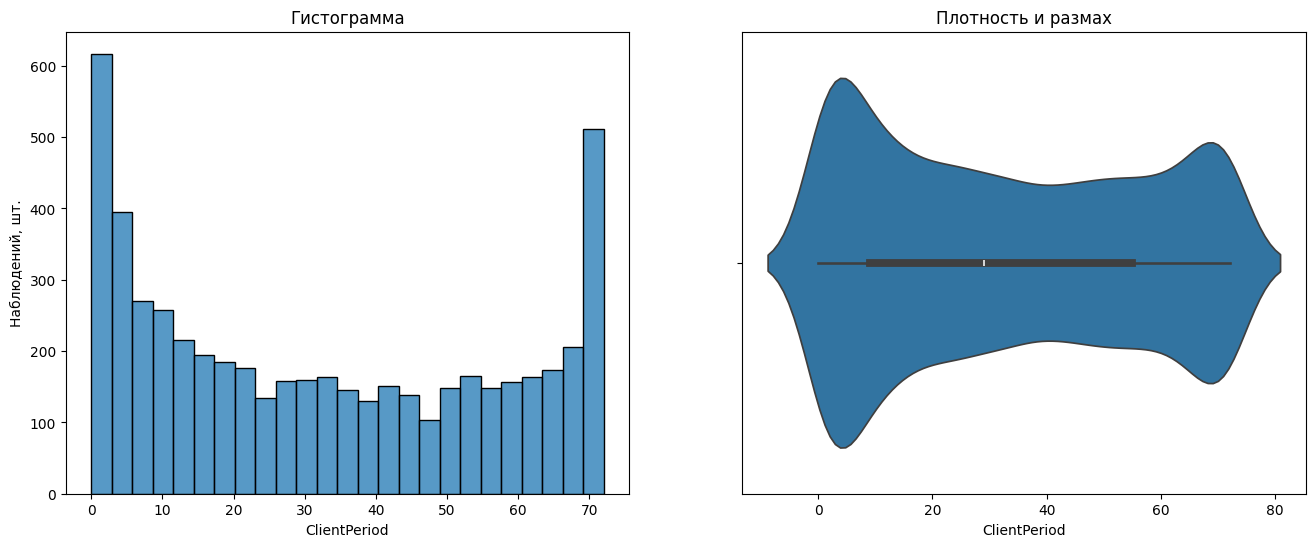

In [14]:
eda_visualize(df["ClientPeriod"])

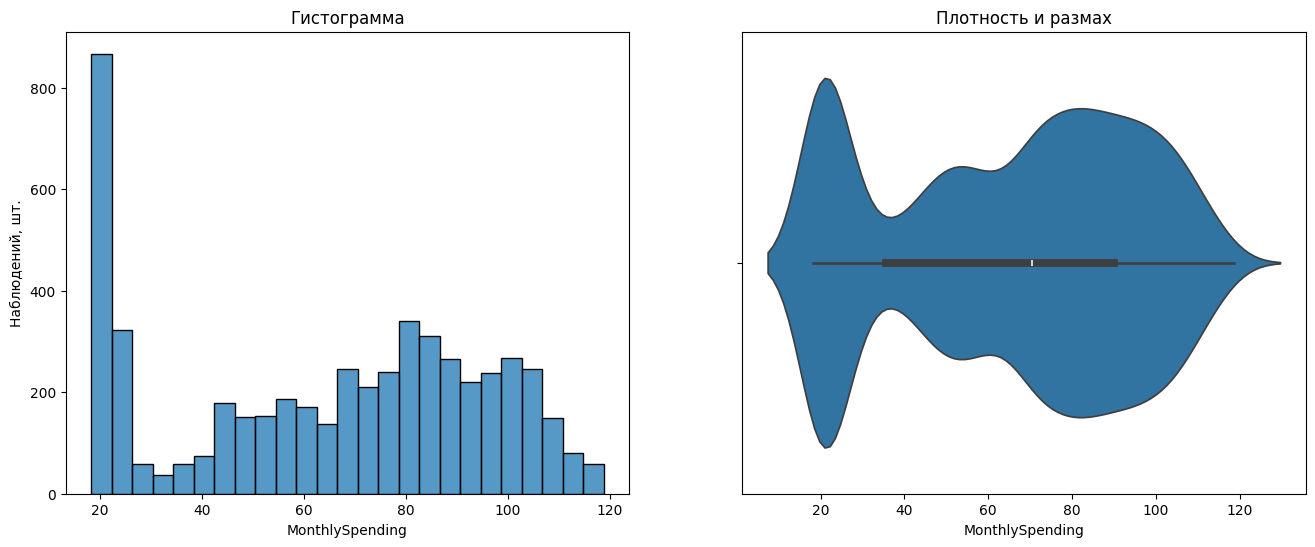

In [15]:
eda_visualize(df["MonthlySpending"])

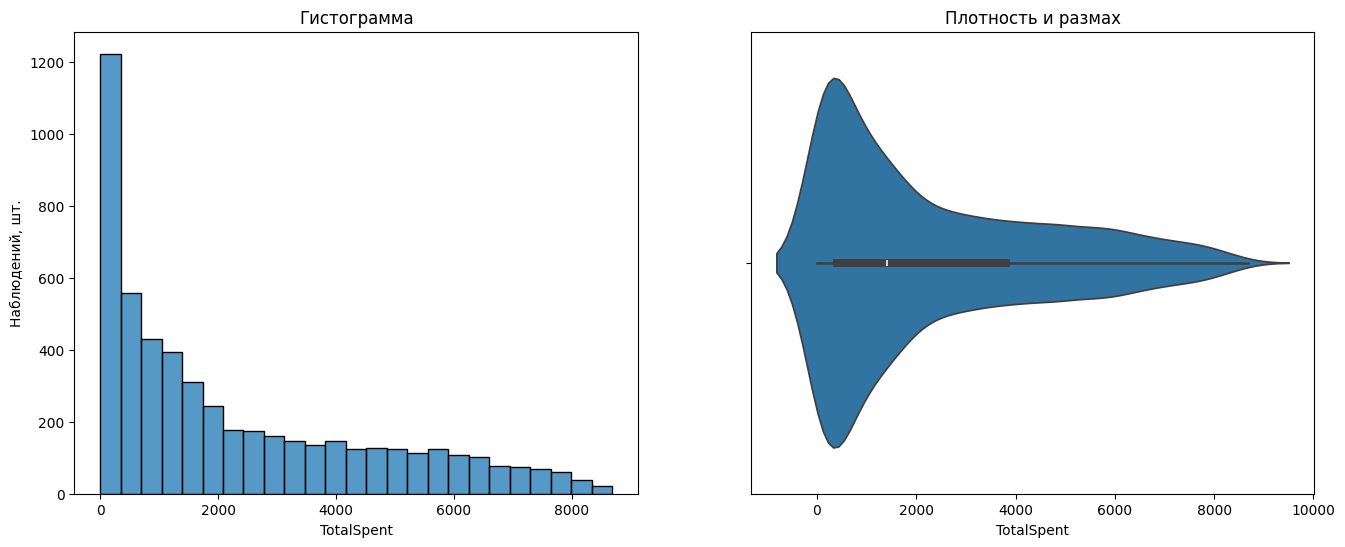

In [16]:
eda_visualize(df["TotalSpent"])

# Корреляция

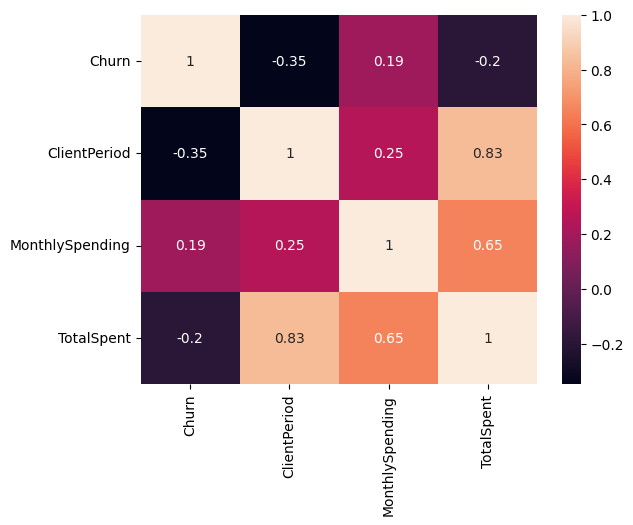

In [17]:
sns.heatmap(df[["Churn", "ClientPeriod", "MonthlySpending", "TotalSpent"]].corr(), annot=True);

# Хи-тест

In [18]:
def chi_test(col):
    ct = pd.crosstab(df[col], df['Churn'])
    statistic, pvalue, dof, expected  = st.chi2_contingency(ct)
    print(f"P-value: for {col}", pvalue)

In [19]:
cols = categorical_cols
for c in cols:
    chi_test(c)

P-value: for HasPartner 3.4836186469174845e-26
P-value: for Sex 0.5768736341964421
P-value: for IsSeniorCitizen 3.863437007724606e-30
P-value: for HasPhoneService 0.5019844674047159
P-value: for HasMovieSubscription 0.00014044418468952928
P-value: for HasChild 7.091784881034045e-32
P-value: for HasMultiplePhoneNumbers 0.0025030627783341384
P-value: for HasInternetService 7.273794373784286e-115
P-value: for HasOnlineSecurityService 1.573966602824722e-39
P-value: for HasOnlineBackup 4.5736174178764743e-10
P-value: for HasDeviceProtection 1.364613720380044e-06
P-value: for HasTechSupportAccess 1.1956962837748674e-32
P-value: for HasOnlineTV 9.086914418685944e-06
P-value: for HasContractPhone 7.250331956736594e-191
P-value: for IsBillingPaperless 2.2391937482381083e-44
P-value: for PaymentMethod 4.739912130247993e-101


# Взаимная информация

In [20]:
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

mi_scores = mutual_info_regression(df_encoded.drop(columns=["Churn"]), df_encoded["Churn"], random_state=79)
mic_data = pd.DataFrame()
mic_data['feature'] = df_encoded.drop(columns=["Churn"]).columns
mic_data['MIC'] = mi_scores
  
mic_data.sort_values(by='MIC', ascending=False)

,feature,MIC
0,ClientPeriod,0.101169
18,HasContractPhone_Two year,0.071037
17,HasContractPhone_One year,0.050724
10,HasInternetService_Fiber optic,0.046789
1,MonthlySpending,0.046056
2,TotalSpent,0.043347
19,IsBillingPaperless_Yes,0.036457
21,PaymentMethod_Electronic check,0.036163
16,HasOnlineTV_Yes,0.026509
5,IsSeniorCitizen_1,0.025313


# Моделирование

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    df,
    df["Churn"],
    test_size=0.2,
    random_state=79,
    shuffle=True,
    stratify=df["Churn"],
)

In [22]:
scaler_list = [
    None,
    MinMaxScaler(),
    StandardScaler(),
    RobustScaler(),
    PowerTransformer(),
    QuantileTransformer(random_state=79),
    QuantileTransformer(random_state=79, output_distribution='normal'),
]

In [23]:
drop_columns = ["Churn", "Sex", "IsSeniorCitizen", "HasPartner", "HasPhoneService", 'HasMovieSubscription']
cols_for_encoding = categorical_cols
columns_to_merge = ["ClientPeriod", "MonthlySpending", "TotalSpent"]

preprocessor = ColumnTransformer(
    transformers=[
        ('column_dropper', 'drop', drop_columns),
        ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False).set_output(transform='pandas'), cols_for_encoding),
        ('pca', PCA(n_components=2, random_state=79), columns_to_merge),
    ],
    remainder='passthrough',
)

## LogisticRegression

In [24]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()), # масштабирование
    # ('poly', PolynomialFeatures(interaction_only=True, degree=3, include_bias=False)),
    ('model', LogisticRegression(random_state=79, penalty="l2", max_iter=10000)),
])
params = {
    "scaler": scaler_list,
    'preprocessor__pca__n_components': [1, 2, 3],
    'preprocessor__pca': [PCA(random_state=79), TruncatedSVD(random_state=79)],
    "model__C": [10 ** x for x in range(-3, 4)],
}

gs = GridSearchCV(
    pipeline,
    params,
    cv=4,
    scoring='roc_auc',
    n_jobs=-1,
)
gs.fit(df, df["Churn"])
prediction = gs.predict_proba(X_test)
gs.best_score_

0.8472555994087121

0.8481124240166074

In [25]:
gs.best_params_

{'model__C': 0.1,
 'preprocessor__pca': TruncatedSVD(random_state=79),
 'preprocessor__pca__n_components': 3,
 'scaler': PowerTransformer()}

### Permutation Importance

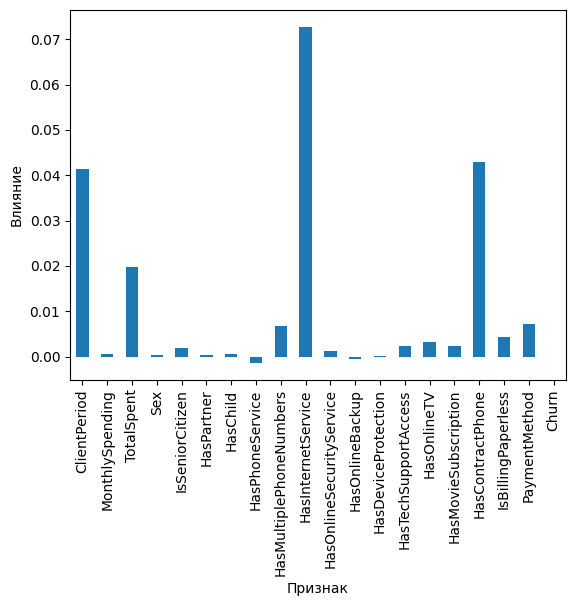

In [26]:
perm_importances = pd.Series(permutation_importance(
    gs.best_estimator_,
    X_test,
    y_test,
    random_state=79,
    scoring='roc_auc',
    n_jobs=-1
)['importances_mean'], index=X_test.columns)
perm_importances.plot(kind='bar');
plt.xlabel('Признак')
plt.ylabel('Влияние');

### Разделение классов

In [27]:
def class_separation(model):
    projection = model.fit_transform(X_train[["ClientPeriod", "MonthlySpending", "TotalSpent"]])
    print(model.explained_variance_ratio_)
    plt.scatter(projection[:,0], projection[:,1], c=y_train);

[9.99861421e-01 1.21682402e-04]


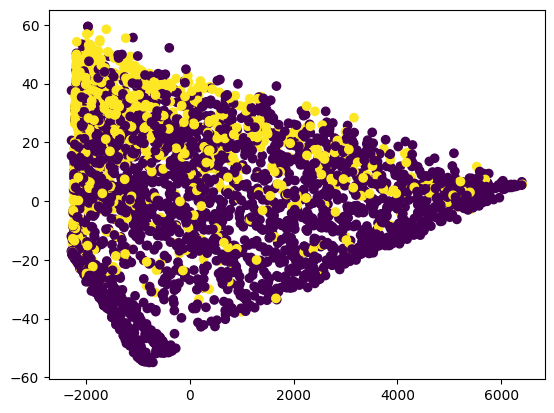

In [28]:
class_separation(PCA(n_components=2))

[9.99756964e-01 1.97336344e-04]


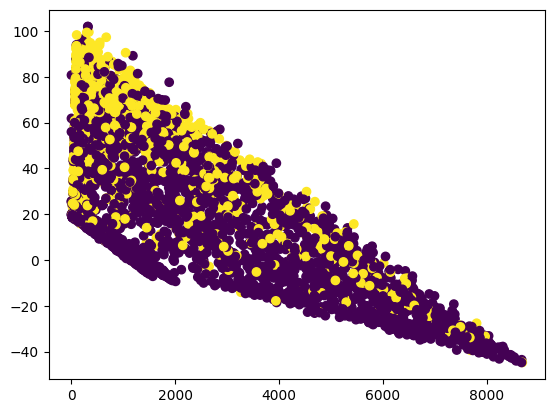

In [29]:
class_separation(TruncatedSVD(n_components=2))

In [30]:
lda = LinearDiscriminantAnalysis(n_components=1)
projection = lda.fit_transform(X_train[["ClientPeriod", "MonthlySpending", "TotalSpent"]], y_train)
lda.explained_variance_ratio_, projection

(array([1.]),
 array([[ 0.81781365],
        [ 1.83141509],
        [ 1.55773831],
        ...,
        [-0.94162953],
        [-0.78493389],
        [ 0.8409182 ]]))

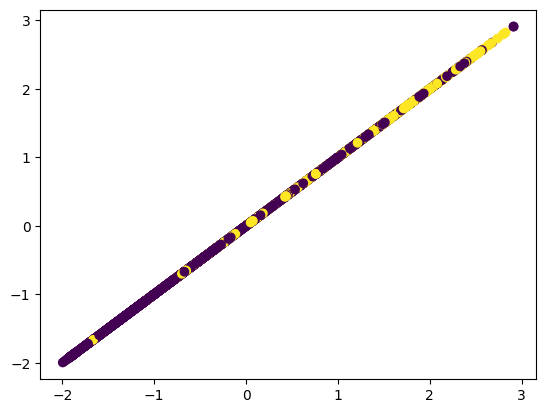

In [31]:
plt.scatter(projection[:,0], projection[:,0], c=y_train);

## RandomForestClassifier

In [32]:
pipe = Pipeline([
    ('preprocessor', preprocessor),               
    ('model', RandomForestClassifier(random_state=79)),
])
tree_params = {
    'model__max_depth':range(3, 8),
    "model__criterion": ["entropy", "gini"],
    "model__n_estimators": [100, 200, 500, 1000],
    'preprocessor__pca__n_components': [1, 2, 3],
    'preprocessor__pca': [PCA(random_state=79), TruncatedSVD(random_state=79)],
}
rf_tree_gs = GridSearchCV(pipe, tree_params, cv=4, scoring='roc_auc', n_jobs=-1)

In [33]:
rf_tree_gs.fit(df, df["Churn"])
rf_tree_gs.best_score_

0.8430082626356956

0.8430082626356956

In [34]:
rf_tree_gs.best_params_

{'model__criterion': 'entropy',
 'model__max_depth': 6,
 'model__n_estimators': 200,
 'preprocessor__pca': TruncatedSVD(random_state=79),
 'preprocessor__pca__n_components': 2}

### Permutation Importance

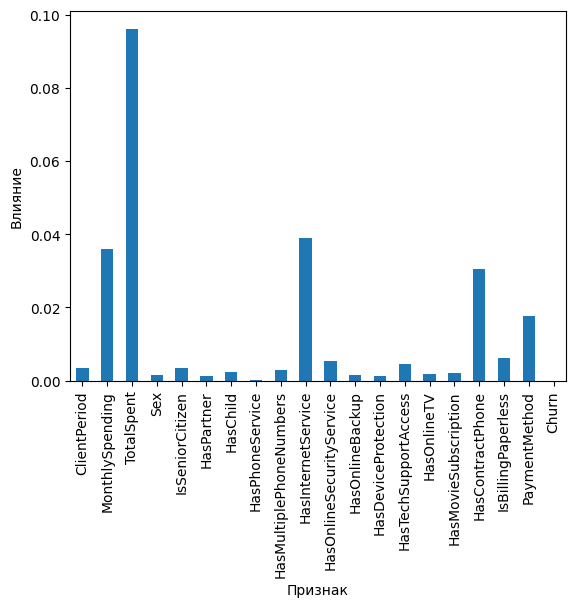

In [35]:
perm_importances = pd.Series(permutation_importance(
    rf_tree_gs.best_estimator_,
    X_test,
    y_test,
    random_state=79,
    scoring='roc_auc',
    n_jobs=-1
)['importances_mean'], index=X_test.columns)
perm_importances.plot(kind='bar');
plt.xlabel('Признак')
plt.ylabel('Влияние');

## ExtraTreesClassifier

In [36]:
pipe = Pipeline([
    ('preprocessor', preprocessor),              
    ('model', ExtraTreesClassifier(random_state=79)),
])
tree_params = {
    'model__max_depth':range(3, 8),
    "model__criterion": ["entropy", "gini"],
    "model__n_estimators": [100, 200, 500, 1000],
    'preprocessor__pca__n_components': [1, 2, 3],
    'preprocessor__pca': [PCA(random_state=79), TruncatedSVD(random_state=79)],
}
et_tree_gs = GridSearchCV(pipe, tree_params, cv=4, scoring='roc_auc', n_jobs=-1)

In [37]:
et_tree_gs.fit(df, df["Churn"])
et_tree_gs.best_score_

0.8388750424393558

In [38]:
et_tree_gs.best_params_

{'model__criterion': 'entropy',
 'model__max_depth': 6,
 'model__n_estimators': 200,
 'preprocessor__pca': TruncatedSVD(random_state=79),
 'preprocessor__pca__n_components': 3}

### Permutation Importance

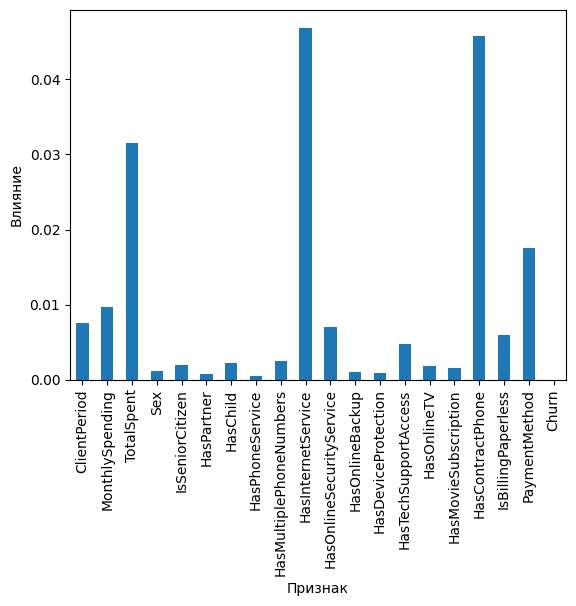

In [39]:
perm_importances = pd.Series(permutation_importance(
    et_tree_gs.best_estimator_,
    X_test,
    y_test,
    random_state=79,
    scoring='roc_auc',
    n_jobs=-1
)['importances_mean'], index=X_test.columns)
perm_importances.plot(kind='bar');
plt.xlabel('Признак')
plt.ylabel('Влияние');

## GradientBoostingClassifier

In [40]:
params = {
    'model__max_depth':range(3, 8),
    "model__n_estimators": [100, 200, 500, 1000],
    "model__learning_rate": [0.1],
    'preprocessor__pca__n_components': [1, 2, 3],
    'preprocessor__pca': [PCA(random_state=79), TruncatedSVD(random_state=79)],
}

In [41]:
modelClf = GradientBoostingClassifier(max_depth=2, n_estimators=150, random_state=79, learning_rate=1)
pipe = Pipeline([
    ('preprocessor', preprocessor),               
    ('model', modelClf),
])
boost_gs = GridSearchCV(pipe, params, cv=4, scoring="roc_auc", n_jobs=-1)

In [42]:
boost_gs.fit(df, df["Churn"])
boost_gs.best_score_

0.8428086326313375

In [43]:
boost_gs.best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__n_estimators': 100,
 'preprocessor__pca': PCA(random_state=79),
 'preprocessor__pca__n_components': 1}

### Permutation Importance

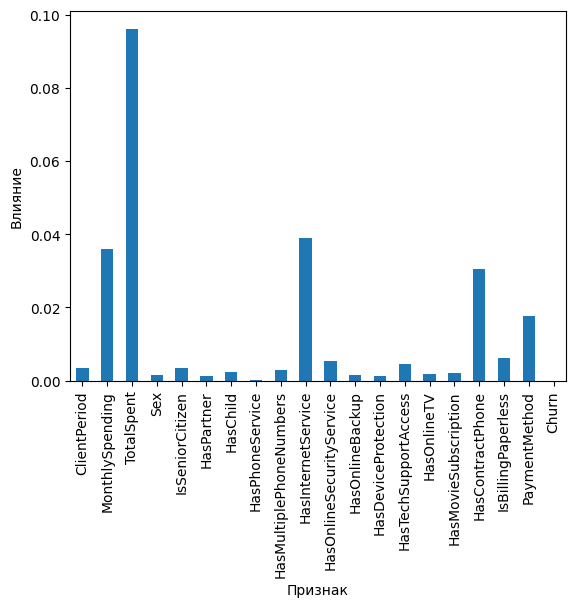

In [44]:
perm_importances = pd.Series(permutation_importance(
    rf_tree_gs.best_estimator_,
    X_test,
    y_test,
    random_state=79,
    scoring='roc_auc',
    n_jobs=-1
)['importances_mean'], index=X_test.columns)
perm_importances.plot(kind='bar');
plt.xlabel('Признак')
plt.ylabel('Влияние');

## StackingClassifier

In [61]:
sc = StackingClassifier(
    estimators=[
        ('lr', gs.best_estimator_),
        ('rf', rf_tree_gs.best_estimator_),
        ('et', et_tree_gs.best_estimator_),
        ('gb', boost_gs.best_estimator_),
    ],
    final_estimator=GaussianNB(),
)
sc.fit(X_train, y_train)
pred = sc.predict_proba(X_test)

In [62]:
roc_auc_score(y_test, pred[:, 1])

0.8432652584899055

## VotingClassifier

In [63]:
vc = VotingClassifier(
    estimators=[
        ('lr', gs.best_estimator_),
        ('rf', rf_tree_gs.best_estimator_),
        ('et', et_tree_gs.best_estimator_),
        ('gb', boost_gs.best_estimator_),
    ],
    voting='soft',
)
vc.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('column_dropper',
                                                                                'drop',
                                                                                ['Churn',
                                                                                 'Sex',
                                                                                 'IsSeniorCitizen',
                                                                                 'HasPartner',
                                                                                 'HasPhoneService',
                                                                                 'HasMovieSubscription']),
                                                                               ('encoder',
                                                                                OneHotEncoder(drop='first',
                                                                                              handle_unknown='ignore',
                                                                                              sparse_output=False),
                                                                                ['HasPartner',
                                                                                 'Sex',
                                                                                 'IsSeniorC...
                                                                                 'HasInternetService',
                                                                                 'HasOnlineSecurityService',
                                                                                 'HasOnlineBackup',
                                                                                 'HasDeviceProtection',
                                                                                 'HasTechSupportAccess',
                                                                                 'HasOnlineTV',
                                                                                 'HasContractPhone',
                                                                                 'IsBillingPaperless',
                                                                                 'PaymentMethod']),
                                                                               ('pca',
                                                                                PCA(n_components=1,
                                                                                    random_state=79),
                                                                                ['ClientPeriod',
                                                                                 'MonthlySpending',
                                                                                 'TotalSpent'])])),
                                              ('model',
                                               GradientBoostingClassifier(random_state=79))]))],
                 voting='soft')

In [64]:
pred = vc.predict_proba(X_test)

In [65]:
roc_auc_score(y_test, pred[:, 1])

0.8431205508227332

In [ ]:
test_df = pd.read_csv('test.csv')
test_df["TotalSpent"] = test_df["TotalSpent"].apply(lambda x: "0" if x == " " else x)
test_df = test_df.astype({"TotalSpent": "float64"})

In [ ]:
sub_pred = gs.best_estimator_.predict_proba(test_df)

In [ ]:
sub_pred[:, 1]

In [ ]:
sub_df = pd.DataFrame(sub_pred[:, 1], columns=['Churn'])

In [ ]:
sub_df.index.name = "Id"

In [ ]:
sub_df

In [ ]:
sub_df.to_csv("submission.csv")